# <a id="table-of-contents"></a>Table of Contents

1. [Intraday Mean Reversion](#section1)
2. [Moving Averages](#subsection1-1)
3. [OBV](#section2)


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(data.head(3))


         Date  Close/Last    Volume    Open    High     Low
0  09/12/2024      559.09  51892740  555.01  559.40  552.74
1  09/11/2024      554.42  75248610  548.70  555.36  539.96
2  09/10/2024      548.79  36394580  548.36  549.15  543.38


In [3]:
# Add new columns with the given calculations
data['High_minus_Open'] = (data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)
data['Open_minus_Low'] = (data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2)
data['intraday_up_MINUS_intraday_down_ratio'] = data['High_minus_Open'] - data['Open_minus_Low']
data['intraday_change'] = (data['Close/Last'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)


data['intraday_range'] = (data['High'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2)
data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)
data['net_Intraday_Movement_Around_Open'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) - ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))

# Create moving average columns
data['MA_5'] = data['Open'].rolling(window=5).mean()
data['MA_14'] = data['Open'].rolling(window=14).mean()
data['MA_50'] = data['Open'].rolling(window=50).mean()

# Create lagged features comparing today's open to these moving averages
data['lag_5'] = (data['Open'] > data['MA_5']).astype(int)
data['lag_14'] = (data['Open'] > data['MA_14']).astype(int)
data['lag_50'] = (data['Open'] > data['MA_50']).astype(int)



data['MA_Crossover_Signal_5_14'] = (data['MA_5'] > data['MA_14']).astype(int)

# Create a binary indicator for whether yesterday's close was above or below the 5-day MA
data['yesterday_close_above_MA_5'] = (data['Close/Last'].shift(1) > data['MA_5']).astype(int)

column_names = data.columns
print(column_names)


Index(['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low',
       'High_minus_Open', 'Open_minus_Low',
       'intraday_up_MINUS_intraday_down_ratio', 'intraday_change',
       'day_change', 'intraday_range', 'opening_gaps',
       'net_Intraday_Movement_Around_Open', 'MA_5', 'MA_14', 'MA_50', 'lag_5',
       'lag_14', 'lag_50', 'MA_Crossover_Signal_5_14',
       'yesterday_close_above_MA_5'],
      dtype='object')


# <a id="section1"></a>Intraday Mean Reversion
[Back to Table of Contents](#table-of-contents)


                                    OLS Regression Results                                   
Dep. Variable:     net_Intraday_Movement_Around_Open   R-squared:                       0.323
Model:                                           OLS   Adj. R-squared:                  0.322
Method:                                Least Squares   F-statistic:                     707.7
Date:                               Tue, 22 Oct 2024   Prob (F-statistic):          8.15e-128
Time:                                       04:32:06   Log-Likelihood:                 5007.7
No. Observations:                               1486   AIC:                        -1.001e+04
Df Residuals:                                   1484   BIC:                        -1.000e+04
Df Model:                                          1                                         
Covariance Type:                           nonrobust                                         
                   coef    std err          t      P>|t|    

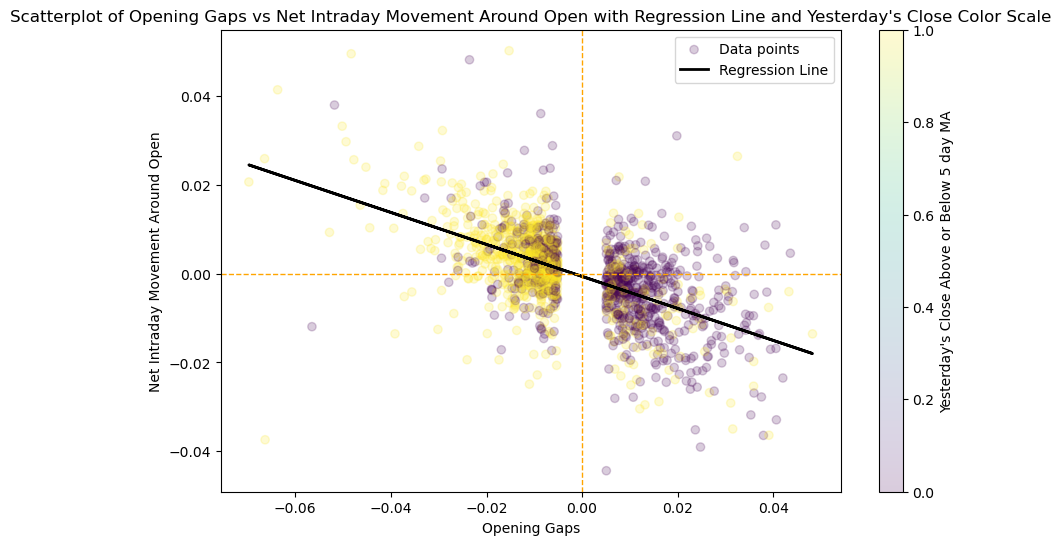

In [4]:
# Calculate the 5-day moving average
data['MA_5'] = data['Close/Last'].rolling(window=5).mean()

# Filter the DataFrame to exclude values with opening_gaps between -0.005 and 0.005 and greater than 0.05
filtered_data = data[(data['opening_gaps'] <= 0.05) & ((data['opening_gaps'] < -0.005) | (data['opening_gaps'] > 0.005))]

# Fit the regression model on the filtered data
X = filtered_data['opening_gaps']
y = filtered_data['net_Intraday_Movement_Around_Open']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(filtered_data['opening_gaps'], filtered_data['net_Intraday_Movement_Around_Open'], 
                      c=filtered_data['yesterday_close_above_MA_5'], cmap='viridis', alpha=0.2, label='Data points')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Yesterday\'s Close Above or Below 5 day MA')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Opening Gaps')
plt.ylabel('Net Intraday Movement Around Open')
plt.title('Scatterplot of Opening Gaps vs Net Intraday Movement Around Open with Regression Line and Yesterday\'s Close Color Scale')

# Add dashed lines at x=0 and y=0
plt.axvline(x=0, color='orange', linestyle='--', linewidth=1)
plt.axhline(y=0, color='orange', linestyle='--', linewidth=1)

# Add legend
plt.legend()

# Show and save the plot
plt.show()


In [5]:
print('''

It's not unusual, and it does carry significance. When combining the data sets for positive and negative gaps, the combined model provides a more comprehensive picture of the 
behavior, capturing broader patterns. Here's why you're seeing those higher values:

Higher R-squared: This indicates that the combined model explains a larger proportion of the variance in net intraday movement. Essentially, it captures more of the overall
behavior by integrating both up and down gaps.

Higher Coefficient: The larger coefficient suggests that opening gaps have a more pronounced impact on net intraday movement when viewed collectively.

Higher Absolute T-value: The stronger t-value underlines the statistical significance of the relationship, implying that your findings are highly unlikely to be due to random 
chance.

In essence, combining the datasets amplifies the signal of the relationship, making it more robust and detectable. This comprehensive approach gives you a clearer understanding of
the market dynamics at play.

Exactly! What you're saying lines up with our logic. Typically, larger down gaps tend to occur when prices are above the 5-day MA, 
signaling some potential pullback or profit-taking

''')



It's not unusual, and it does carry significance. When combining the data sets for positive and negative gaps, the combined model provides a more comprehensive picture of the 
behavior, capturing broader patterns. Here's why you're seeing those higher values:

Higher R-squared: This indicates that the combined model explains a larger proportion of the variance in net intraday movement. Essentially, it captures more of the overall
behavior by integrating both up and down gaps.

Higher Coefficient: The larger coefficient suggests that opening gaps have a more pronounced impact on net intraday movement when viewed collectively.

Higher Absolute T-value: The stronger t-value underlines the statistical significance of the relationship, implying that your findings are highly unlikely to be due to random 
chance.

In essence, combining the datasets amplifies the signal of the relationship, making it more robust and detectable. This comprehensive approach gives you a clearer understanding of

                            OLS Regression Results                            
Dep. Variable:         Open_minus_Low   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     157.5
Date:                Tue, 22 Oct 2024   Prob (F-statistic):           2.11e-32
Time:                        04:32:06   Log-Likelihood:                 2252.4
No. Observations:                 633   AIC:                            -4501.
Df Residuals:                     631   BIC:                            -4492.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0042      0.001      7.914   

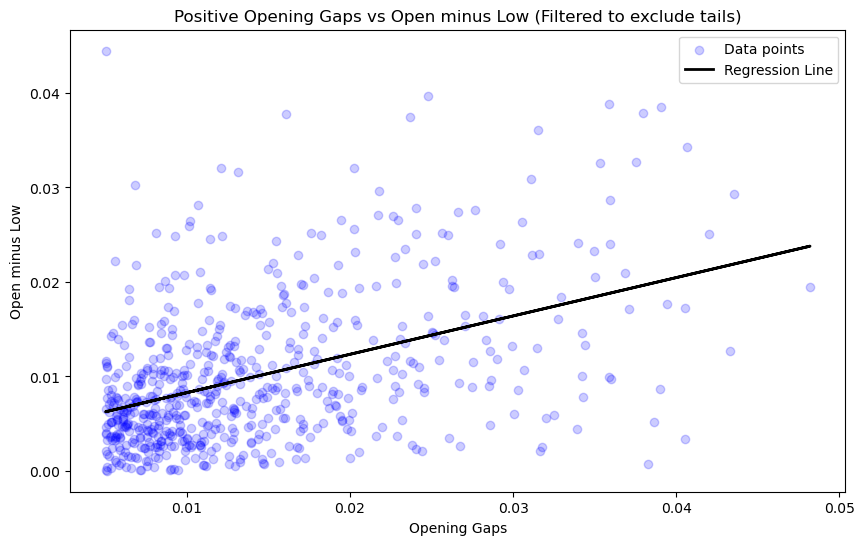


shows mean reversion for the up gaps




In [6]:
# Filter the DataFrame to include only positive opening gaps greater than 0.005 and less than 0.05
filtered_data = data[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] <= 0.05)]

# Fit the regression model with opening_gaps driving Open_minus_Low
X = filtered_data['opening_gaps']
y = filtered_data['Open_minus_Low']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['opening_gaps'], filtered_data['Open_minus_Low'], color='blue', alpha=0.2, label='Data points')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Opening Gaps')
plt.ylabel('Open minus Low')
plt.title('Positive Opening Gaps vs Open minus Low (Filtered to exclude tails)')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

print('''
shows mean reversion for the up gaps

''')

                            OLS Regression Results                            
Dep. Variable:        High_minus_Open   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     304.4
Date:                Tue, 22 Oct 2024   Prob (F-statistic):           1.93e-58
Time:                        04:32:07   Log-Likelihood:                 3144.2
No. Observations:                 845   AIC:                            -6284.
Df Residuals:                     843   BIC:                            -6275.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0023      0.000      5.654   

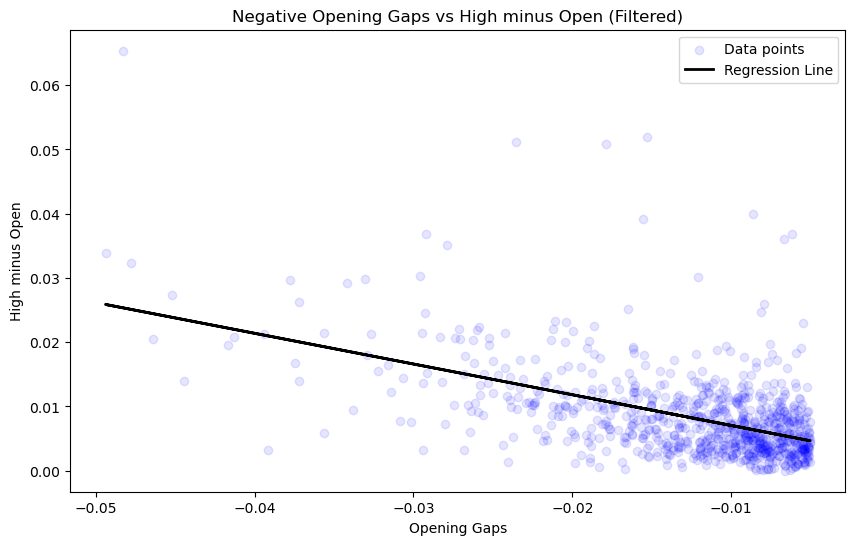



You're right: this data shows an even stronger mean reversion for down gaps. The significant negative coefficient (-0.4782) indicates that as the negative opening gap widens,
the high-minus-open value tends to decrease significantly. This supports the notion of a robust mean reversion effect for down gaps. The R-squared value of 0.265 is notable, 
indicating that 26.5% of the variability in High_minus_Open is explained by the negative opening gaps.




In [7]:
# Filter the DataFrame to include only negative opening gaps between -0.05 and -0.005
filtered_data = data[(data['opening_gaps'] < -0.005) & (data['opening_gaps'] >= -0.05)]

# Fit the regression model with opening_gaps driving High_minus_Open
X = filtered_data['opening_gaps']
y = filtered_data['High_minus_Open']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['opening_gaps'], filtered_data['High_minus_Open'], color='blue', alpha=0.1, label='Data points')

# Plot the regression line
plt.plot(filtered_data['opening_gaps'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Opening Gaps')
plt.ylabel('High minus Open')
plt.title('Negative Opening Gaps vs High minus Open (Filtered)')

# Add legend
plt.legend()

# Show and save the plot
plt.show()


print('''

You're right: this data shows an even stronger mean reversion for down gaps. The significant negative coefficient (-0.4782) indicates that as the negative opening gap widens,
the high-minus-open value tends to decrease significantly. This supports the notion of a robust mean reversion effect for down gaps. The R-squared value of 0.265 is notable, 
indicating that 26.5% of the variability in High_minus_Open is explained by the negative opening gaps.

''')

## <a id="subsection1-1"></a> Moving Averages: Today's Price Change

                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     465.6
Date:                Tue, 22 Oct 2024   Prob (F-statistic):           6.99e-95
Time:                        04:32:07   Log-Likelihood:                 7929.3
No. Observations:                2515   AIC:                        -1.585e+04
Df Residuals:                    2513   BIC:                        -1.584e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0041      0.000    -15.205      0.0

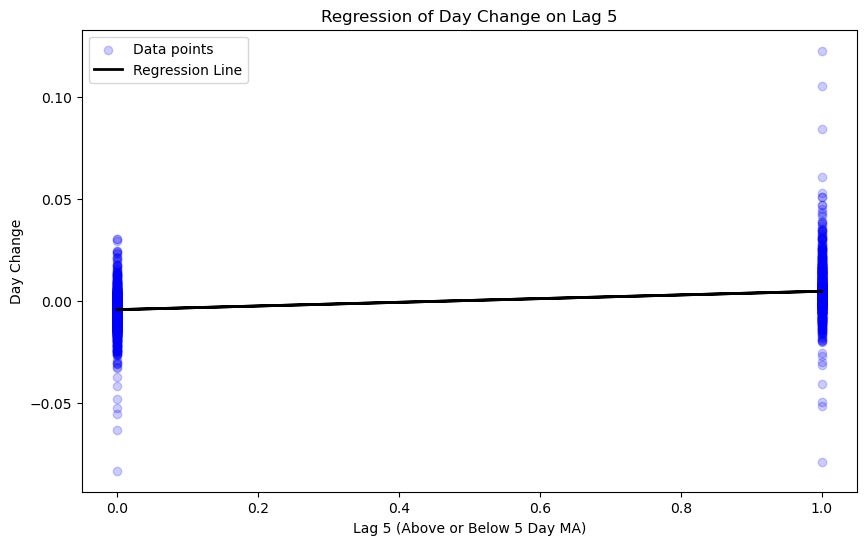

In [8]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['lag_5', 'day_change'])

# Independent variable (lag_5) and dependent variable (day_change)
X = clean_data[['lag_5']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['lag_5'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')
plt.plot(clean_data['lag_5'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Lag 5 (Above or Below 5 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Lag 5')

# Add legend
plt.legend()

# Show and save the plot
plt.show()


                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     197.0
Date:                Tue, 22 Oct 2024   Prob (F-statistic):           3.87e-43
Time:                        04:32:07   Log-Likelihood:                 7810.5
No. Observations:                2515   AIC:                        -1.562e+04
Df Residuals:                    2513   BIC:                        -1.561e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0027      0.000     -9.832      0.0

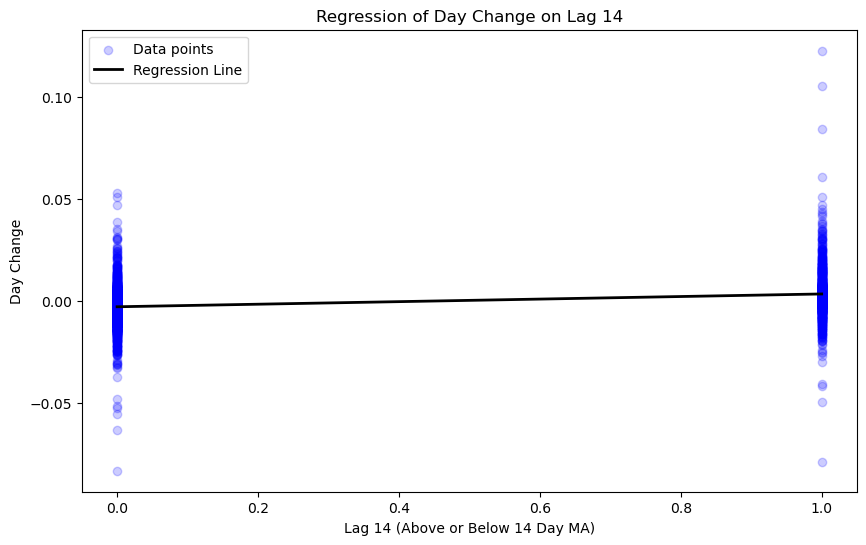

In [9]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['lag_14', 'day_change'])

# Independent variable (lag_5) and dependent variable (day_change)
X = clean_data[['lag_14']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['lag_14'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')
plt.plot(clean_data['lag_14'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Lag 14 (Above or Below 14 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Lag 14')

# Add legend
plt.legend()

# Show and save the plot
plt.show()


                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     49.89
Date:                Tue, 22 Oct 2024   Prob (F-statistic):           2.10e-12
Time:                        04:32:07   Log-Likelihood:                 7740.3
No. Observations:                2515   AIC:                        -1.548e+04
Df Residuals:                    2513   BIC:                        -1.546e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.000     -5.176      0.0

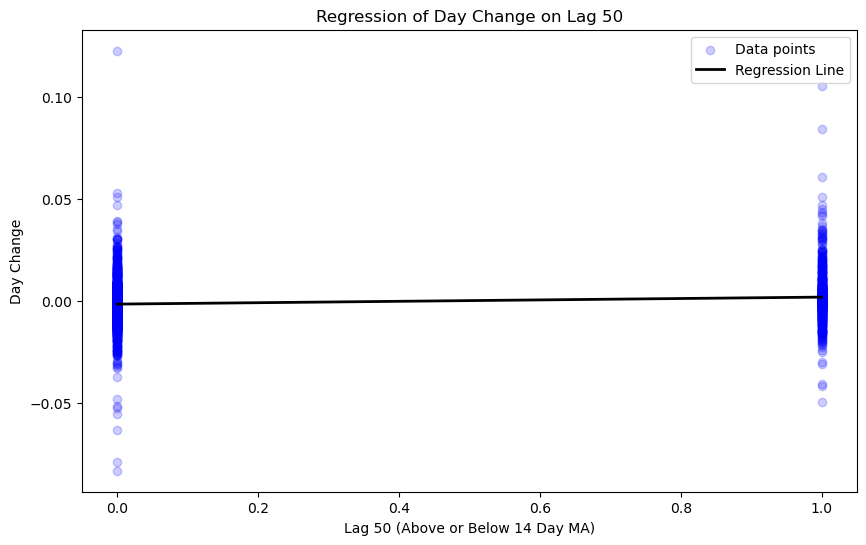

In [10]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['lag_50', 'day_change'])

# Independent variable (lag_5) and dependent variable (day_change)
X = clean_data[['lag_50']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['lag_50'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')
plt.plot(clean_data['lag_50'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Lag 50 (Above or Below 14 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Lag 50')

# Add legend
plt.legend()

# Show and save the plot
plt.show()


In [11]:
print('''
all 3 regressions indicate MA are immaterial as predictor or day price change
''')


all 3 regressions indicate MA are immaterial as predictor or day price change



                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     161.3
Date:                Tue, 22 Oct 2024   Prob (F-statistic):           1.28e-95
Time:                        04:32:07   Log-Likelihood:                 7937.2
No. Observations:                2515   AIC:                        -1.587e+04
Df Residuals:                    2511   BIC:                        -1.584e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0045      0.000    -15.494      0.0

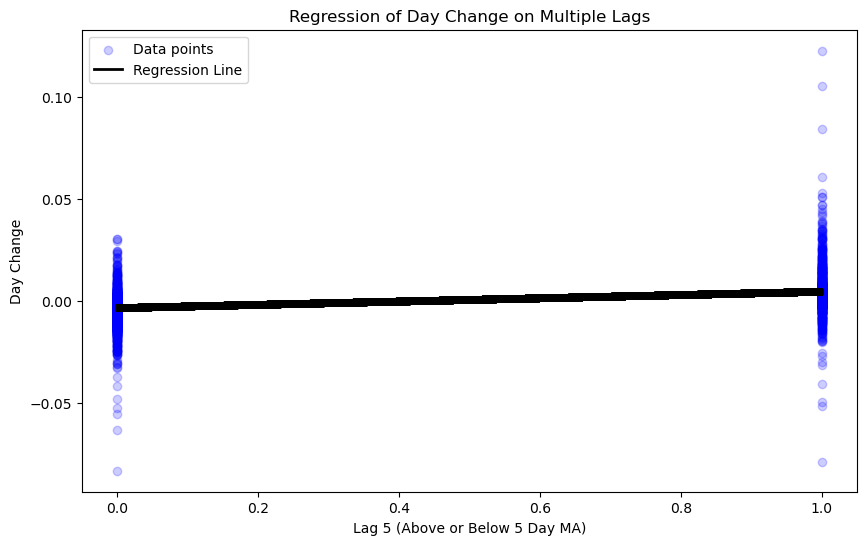

In [12]:
# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['lag_5', 'lag_14', 'lag_50', 'day_change'])

# Independent variables and dependent variable
X = clean_data[['lag_5', 'lag_14', 'lag_50']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot for one of the variables (lag_5 as an example)
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['lag_5'], clean_data['day_change'], color='blue', alpha=0.2, label='Data points')

# Plot the regression line for one variable (lag_5)
plt.plot(clean_data['lag_5'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Lag 5 (Above or Below 5 Day MA)')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Multiple Lags')

# Add legend
plt.legend()

# Show and save the plot
plt.savefig('regression_day_change_on_multiple_lags.png', dpi=300)
plt.show()


In [13]:
print('''

Exactly. Multicollinearity is a valid concern here. If the 5-day MA significantly predicts price movement, the 14-day and 50-day MAs are likely to be highly correlated with it,
as they incorporate overlapping data. You're correct. Multicollinearity doesn't affect the coefficients themselves but does inflate the standard errors, impacting the t-scores 
and p-values.

Given your coefficients are already very low and the R-squared is modest, it suggests that these variables (lag_5, lag_14, and lag_50) aren't strong predictors of day change. 
The significant p-values for lag_5 and lag_14 indicate they have some relationship, but their practical impact is minimal. The 50-day lag is particularly irrelevant with a high 
p-value and near-zero coefficient.

''')



Exactly. Multicollinearity is a valid concern here. If the 5-day MA significantly predicts price movement, the 14-day and 50-day MAs are likely to be highly correlated with it,
as they incorporate overlapping data. You're correct. Multicollinearity doesn't affect the coefficients themselves but does inflate the standard errors, impacting the t-scores 
and p-values.

Given your coefficients are already very low and the R-squared is modest, it suggests that these variables (lag_5, lag_14, and lag_50) aren't strong predictors of day change. 
The significant p-values for lag_5 and lag_14 indicate they have some relationship, but their practical impact is minimal. The 50-day lag is particularly irrelevant with a high 
p-value and near-zero coefficient.




In [14]:

# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['lag_5', 'lag_14', 'lag_50', 'day_change'])

# Independent variables
X = clean_data[['lag_5', 'lag_14', 'lag_50']]

# Add a constant term to the predictor
X = sm.add_constant(X)

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


  feature       VIF
0   const  1.974723
1   lag_5  1.396341
2  lag_14  1.632326
3  lag_50  1.241787


In [15]:
print('''

Exactly. The low VIF values indicate that these moving averages are not strongly related to each other in predicting daily changes. This reinforces the idea that the data lacks 
a significant trend within the 5, 14, and 50-day windows. It suggests a level of randomness, with no clear pattern or momentum over these periods. So, the moving averages are not 
trending indicators in this context. What's your next data adventure?

''')



Exactly. The low VIF values indicate that these moving averages are not strongly related to each other in predicting daily changes. This reinforces the idea that the data lacks 
a significant trend within the 5, 14, and 50-day windows. It suggests a level of randomness, with no clear pattern or momentum over these periods. So, the moving averages are not 
trending indicators in this context. What's your next data adventure?




                            OLS Regression Results                            
Dep. Variable:             day_change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.253
Date:                Tue, 22 Oct 2024   Prob (F-statistic):              0.263
Time:                        04:32:09   Log-Likelihood:                 7567.8
No. Observations:                2467   AIC:                        -1.513e+04
Df Residuals:                    2465   BIC:                        -1.512e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0005      0.001     

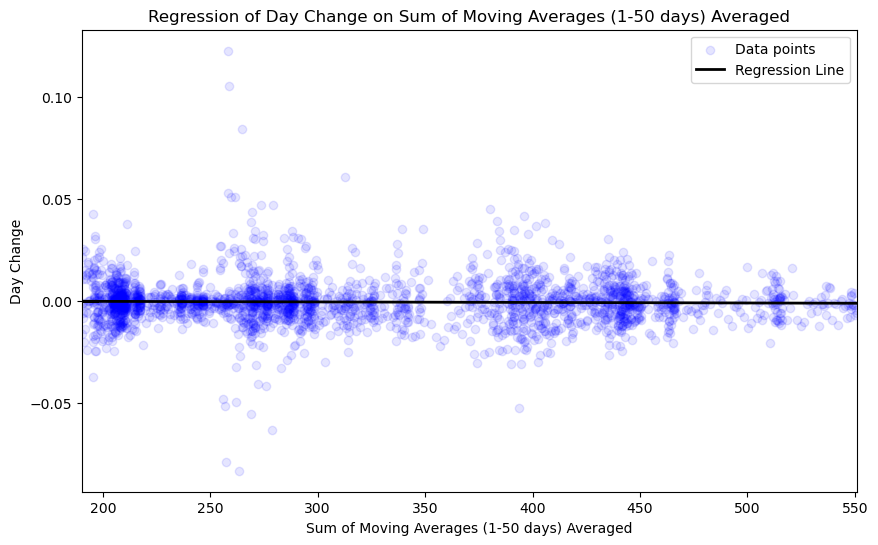

In [16]:
# Initialize the column to store the sum of moving averages
data['Sum_MA_1_50'] = 0

# Calculate and sum the moving averages from 1 to 50 days
for i in range(1, 51):
    # Calculate the moving average for each window size 'i'
    ma = data['Close/Last'].rolling(window=i).mean()
    # Add the calculated moving average to 'Sum_MA_1_50'
    data['Sum_MA_1_50'] += ma

# Divide by 50 to get the average
data['Sum_MA_1_50_Avg'] = data['Sum_MA_1_50'] / 50

# Ensure 'day_change' is defined
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)

# Drop rows with NaN values in the columns of interest
clean_data = data.dropna(subset=['Sum_MA_1_50_Avg', 'day_change'])

# Independent variable and dependent variable
X = clean_data[['Sum_MA_1_50_Avg']]
y = clean_data['day_change']

# Add a constant term to the predictor
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the OLS results
print(model.summary())

# Predict values
predictions = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(clean_data['Sum_MA_1_50_Avg'], clean_data['day_change'], color='blue', alpha=0.1, label='Data points')

# Plot the regression line
plt.plot(clean_data['Sum_MA_1_50_Avg'], predictions, color='black', linewidth=2, label='Regression Line')

# Add labels and title
plt.xlabel('Sum of Moving Averages (1-50 days) Averaged')
plt.ylabel('Day Change')
plt.title('Regression of Day Change on Sum of Moving Averages (1-50 days) Averaged')

# Set the x-axis limit to fit the range of 'Sum_MA_1_50_Avg'
plt.xlim(clean_data['Sum_MA_1_50_Avg'].min(), clean_data['Sum_MA_1_50_Avg'].max())

# Add legend
plt.legend()

# Show and save the plot
plt.show()


In [17]:
print('''

Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, 
high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor.

This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving
averages, at least in these configurations, don't offer predictive power for daily changes.

''')



Exactly. The OLS results show that the average of the MAs isn't predictive for day-to-day price changes. The small coefficient, 
high p-value, and low R-squared all suggest the sum of moving averages isn't a useful predictor.

This finding aligns with your earlier insights about the lack of significance in individual moving averages. So, it seems like moving
averages, at least in these configurations, don't offer predictive power for daily changes.




# <a id="section2"></a> OBV


In [18]:
data['OBV'] = 0

# Initialize the first value of OBV
data.loc[0, 'OBV'] = data.loc[0, 'Volume']

# Calculate OBV
for i in range(1, len(data)):
    if data.loc[i, 'Close/Last'] > data.loc[i-1, 'Close/Last']:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV'] + data.loc[i, 'Volume']
    elif data.loc[i, 'Close/Last'] < data.loc[i-1, 'Close/Last']:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV'] - data.loc[i, 'Volume']
    else:
        data.loc[i, 'OBV'] = data.loc[i-1, 'OBV']

In [19]:
# Assuming 'data' is your existing DataFrame
data['Original_Index'] = data.index  # Add the Original_Index column to capture current index


        Date  Close/Last        OBV
0 2024-09-12      559.09   51892740
1 2024-09-11      554.42  -23355870
2 2024-09-10      548.79  -59750450
3 2024-09-09      546.41 -100196270
4 2024-09-06      540.36 -168690080


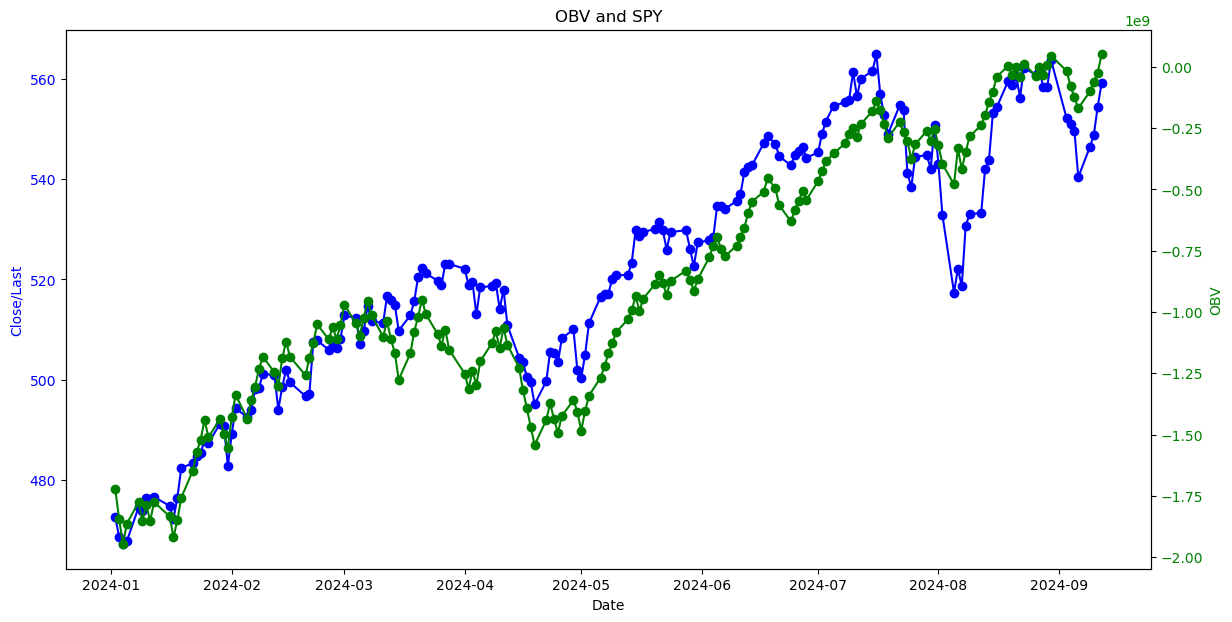


You're capturing the differences between OBV and SPY percentage changes over rolling windows, updating based on the maximum observed difference, and assessing 
retracements to set the OBV_SPY_metric.



In [20]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter data to include only dates in the year 2024
data_2024 = data[data['Date'].dt.year == 2024]

# Display the first few rows to check the new DataFrame
print(data_2024[['Date', 'Close/Last', 'OBV']].head())

# Create dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Close/Last on the first y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Close/Last', color='blue')
ax1.plot(data_2024['Date'], data_2024['Close/Last'], color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for OBV
ax2 = ax1.twinx()
ax2.set_ylabel('OBV', color='green')
ax2.plot(data_2024['Date'], data_2024['OBV'], color='green', marker='o')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title
plt.title('OBV and SPY')

# Show the plot
plt.show()


print('''
You're capturing the differences between OBV and SPY percentage changes over rolling windows, updating based on the maximum observed difference, and assessing 
retracements to set the OBV_SPY_metric.
''')

In [24]:
def calculate_obv_spy_metric_backward(data, initial_window_size=5, threshold=15):
    data['OBV_SPY_metric'] = np.nan  # Initialize the new independent variable column
    data['OBV_SPY_window_length'] = np.nan  # Initialize column for window length
    data['OBV_SIGNAL'] = 0  # Initialize column for OBV signals
    
    for i in range(initial_window_size, len(data)):  # Start from initial_window_size to ensure at least 5 loops
        max_diff = 0
        j = 0
        
        while i - j >= 0:
            obv_early = data['OBV'].iloc[i-j]
            obv_late = data['OBV'].iloc[0]  # Fixed to the current index
            spy_early = data['Close/Last'].iloc[i-j]
            spy_late = data['Close/Last'].iloc[0]  # Fixed to the current index
            
            obv_pct_change = (obv_late - obv_early) / obv_early * 100
            spy_pct_change = (spy_late - spy_early) * 100  # Ensure spy_pct_change uses the correct calculation
            
            obv_spy_pct_diff = obv_pct_change - spy_pct_change
            abs_current_diff = abs(obv_spy_pct_diff)
            
            if abs_current_diff > max_diff:
                max_diff = abs_current_diff
            
            if j >= initial_window_size:  # Perform retracement check only after 5 loops
                retracement = ((max_diff - abs_current_diff) / max_diff) * 100 if max_diff != 0 else 0
                
                if retracement >= threshold:
                    data.at[i, 'OBV_SIGNAL'] = 1  # Mark OBV signal
                    break
            
            j += 2  # Increment j by 2 to expand window backward
        
        data.at[i, 'OBV_SPY_metric'] = max_diff
        data.at[i, 'OBV_SPY_window_length'] = j

    return data

# Apply the function to the DataFrame
data = calculate_obv_spy_metric_backward(data)

# Drop rows with NaN values in OBV_SPY_metric
data.dropna(subset=['OBV_SPY_metric'], inplace=True)

print(data[['Date', 'OBV', 'OBV_SPY_metric', 'OBV_SPY_window_length', 'OBV_SIGNAL']].head(2))
print('''OBV_SPY_metric is the cumulative percentage change between the OBV and SPY since it last had a 15% retracement,
OBV_SPY_window_length is the length of the window in days.''')
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')


        Date        OBV  OBV_SPY_metric  OBV_SPY_window_length  OBV_SIGNAL
5 2024-09-05 -124425820     1138.414931                    6.0           0
6 2024-09-04  -77200880    13689.216365                    6.0           1
OBV_SPY_metric is the cumulative percentage change between the OBV and SPY since it last had a 15% retracement, OBV_SPY_window_length is the length of the window in days.
It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


In [32]:
# Filter the DataFrame for 'OBV_SPY_window_length' values over 20
filtered_data = data[data['OBV_SPY_window_length'] > 15]

# Sort the filtered DataFrame by the 'Original_Index' column
sorted_filtered_data = filtered_data.sort_values(by='Original_Index')

# Create the "Percent_Change" column for 2% test
data['Percent_Change'] = data['Original_Index'].pct_change() * 100

# Drop NaNs resulting from pct_change calculation
data.dropna(subset=['Percent_Change'], inplace=True)

# Initialize the "New_OBV_Trend" column with 0
data['New_OBV_Trend'] = 0

# Iterate through the DataFrame to set "New_OBV_Trend" based on both conditions
for i in range(1, len(data)):
    if abs(data['Percent_Change'].iloc[i]) >= 2 and abs(data['Original_Index'].iloc[i] - data['Original_Index'].iloc[i-1]) >= 5:
        data.at[i, 'New_OBV_Trend'] = 1

print(data[['Original_Index', 'Date', 'OBV', 'OBV_SPY_metric', 'OBV_SPY_window_length', 'Percent_Change', 'New_OBV_Trend']].head(25))


    Original_Index       Date        OBV  OBV_SPY_metric  \
9                9 2024-08-29    7384160     1356.329050   
10              10 2024-08-28  -33681860    17724.001452   
11              11 2024-08-27    -987960     1356.329050   
12              12 2024-08-26  -36776570    17724.001452   
13              13 2024-08-23   13862820     1356.329050   
14              14 2024-08-22  -42258640    17724.001452   
15              15 2024-08-21    -744040     1169.902475   
16              16 2024-08-20  -34476300    17724.001452   
17              17 2024-08-19    4645490     1681.710164   
18              18 2024-08-16  -39785240    17724.001452   
19              19 2024-08-15 -100632050     1960.126936   
20              20 2024-08-14 -143078980     3165.200878   
21              21 2024-08-13 -195412050     2808.603703   
22              22 2024-08-12 -237954120     3297.023279   
23              23 2024-08-09 -283573680     2808.603703   
24              24 2024-08-08 -346850270